# Exponential Position Scaling Strategy
## Tail Risk and Capital Depletion Under Loss-Triggered Scaling

This notebook examines an exponential position scaling rule, in which exposure is increased multiplicatively following losses and reset to a base level after gains.

This class of rules is often motivated by short-horizon variance suppression: frequent small gains punctuated by rare but severe drawdowns. We analyse the behaviour of this strategy using both a single-path simulation and a Monte Carlo experiment, focusing on tail risk, drawdown formation, and ruin probability.

### Key Characteristics
- Exposure increases exponentially during adverse sequences
- A single extended loss sequence can rapidly exhaust available capital
- Outcomes exhibit strong skewness: many modest gains alongside rare catastrophic losses
- Negative expected value dominates long-run behaviour

The implementation used here corresponds to the project’s exponential scaling rule (internally implemented in the martingale module).


In [1]:
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath(".."))
sys.path.insert(0, os.path.abspath("../src"))

from ..rng import roulette_like_trial
from ..strategies.martingale import martingale_bettor
from ..runner import run_simulation

plt.style.use("seaborn-v0_8-darkgrid")
random.seed(42)

## 1. Simulation Parameters

The following parameters are used for both the single-path and Monte Carlo simulations. Exposure per iteration is intentionally small relative to total capital, so that drawdowns emerge primarily from loss clustering rather than noise.

In [2]:
initial_funds = 10_000
stake = 100
n_rounds = 100
p_win = 0.49

## 2. Single-Path Capital Evolution

We first simulate a single realisation of the capital process under exponential position scaling.

While a single path is not representative of expected performance, it clearly illustrates:

- rapid exposure escalation during loss sequences
- sharp drawdowns driven by path dependence
- the fragility of capital under multiplicative scaling rules


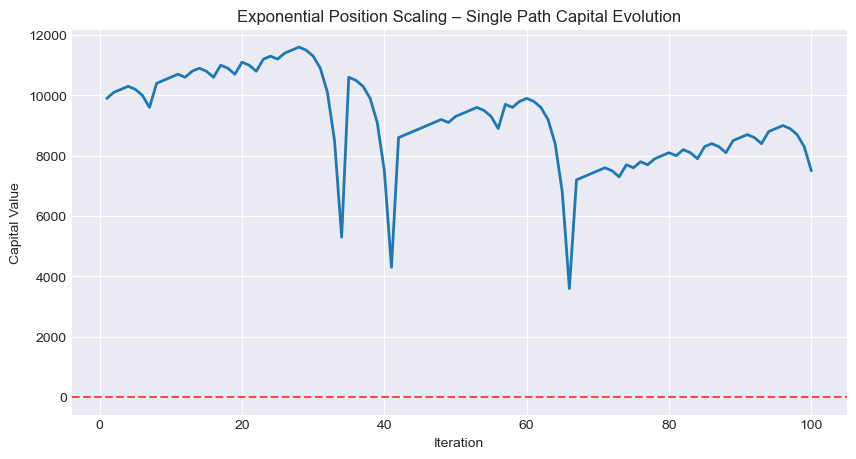

In [3]:
random.seed(42)

def trial():
    return roulette_like_trial(p_win)

wagers, values = martingale_bettor(
    initial_funds=initial_funds,
    initial_stake=stake,
    n_rounds=n_rounds,
    rng_fn=trial
)

plt.figure(figsize=(10,5))
plt.plot(wagers, values, linewidth=2)
plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.xlabel("Iteration")
plt.ylabel("Capital Value")
plt.title("Exponential Position Scaling – Single Path Capital Evolution")
plt.show()

- Capital erosion accelerates rapidly once exposure begins to compound.
- In this particular realisation, ruin is narrowly avoided, though several points lie within one additional loss of total depletion.
- Gains accrue slowly during recovery phases due to exposure resetting after favourable outcomes.


## 3. Monte Carlo Simulation Across Many Paths

We now perform a Monte Carlo experiment across many independent paths in order to characterise the **distribution of outcomes** and estimate **ruin probability** under exponential scaling.


In [4]:
n_bettors = 500

final_values, broke_count = run_simulation(
    martingale_bettor,
    initial_funds,
    stake,
    n_rounds,
    n_bettors,
    p_win=p_win,
    seed=42
)

print("Paths resulting in capital depletion:", broke_count)
print("Ruin probability:", round(broke_count / n_bettors * 100, 2), "%")

mean_value = np.mean(final_values)
median_value = np.median(final_values)

print("Mean final capital:", round(mean_value, 2))
print("Median final capital:", round(median_value, 2))

Paths resulting in capital depletion: 150
Ruin probability: 30.0 %
Mean final capital: 9466.8
Median final capital: 14100.0


## 4. Distribution of Final Capital

The histogram below illustrates the highly skewed distribution of final capital values. Most paths realise modest gains, while a substantial fraction terminate in total capital depletion.


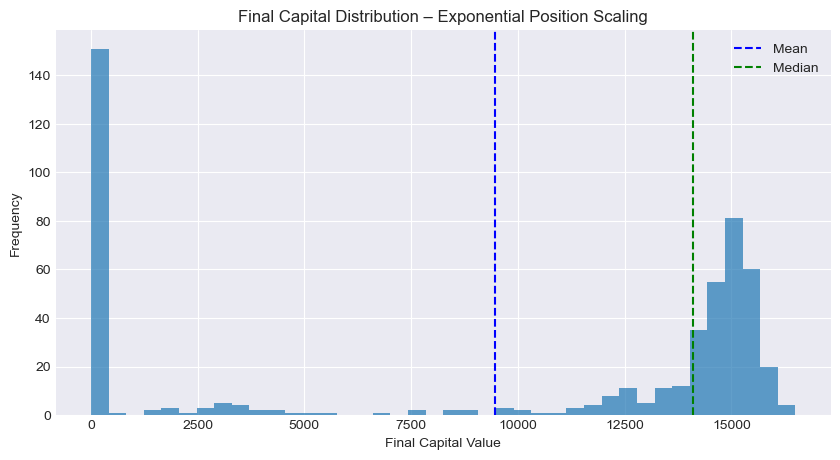

In [5]:
plt.figure(figsize=(10,5))
plt.hist(final_values, bins=40, alpha=0.7)
plt.axvline(mean_value, color="blue", linestyle="--", label="Mean")
plt.axvline(median_value, color="green", linestyle="--", label="Median")
plt.title("Final Capital Distribution – Exponential Position Scaling")
plt.xlabel("Final Capital Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

- The median outcome is positive, reflecting the prevalence of short favourable sequences.
- The mean outcome remains below initial capital due to the influence of rare but extreme losses.
- Ruin probability is substantially higher than under constant position sizing, despite superficially attractive typical outcomes.


## Summary

- Exponential position scaling suppresses short-term variance at the cost of extreme tail risk.
- Rare loss clusters dominate long-run outcomes through catastrophic drawdowns.
- Monte Carlo analysis is essential for revealing the true risk profile of such strategies.
- Under negative expected returns, capital depletion remains inevitable despite positive median outcomes.
